In [1]:
# https://dataframes.juliadata.org/stable/man/getting_started/

In [9]:
# Load installed packages
using DataFrames
using CSV
using Plots
using Lathe
using Lathe.preprocess: TrainTestSplit
using GLM
using Statistics
using StatsPlots
using MLBase

In [10]:
# Load data
df = DataFrame(CSV.File("data/sine440.csv"))
first(df, 5)

,onset,duration,sample_rate,amplitude,phase,frequency,decay,d
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,String
1,0,250,44100,5.25153e-5,2.73962,21534.9,-20.0992,(-4.8329368041734524e-05+2.0545714446678468e-05j)
2,0,250,44100,5.25153e-5,-2.73962,-21534.9,-20.0992,(-4.8329368041734524e-05-2.0545714446678468e-05j)
3,0,250,44100,0.000100237,3.07657,21293.7,-68.687,(-0.00010002537988658094+6.513243716127503e-06j)
4,0,250,44100,0.000100237,-3.07657,-21293.7,-68.687,(-0.00010002537988658094-6.513243716127503e-06j)
5,0,250,44100,0.000108543,3.05488,21929.4,-109.194,(-0.00010813549037133643+9.400643557201682e-06j)


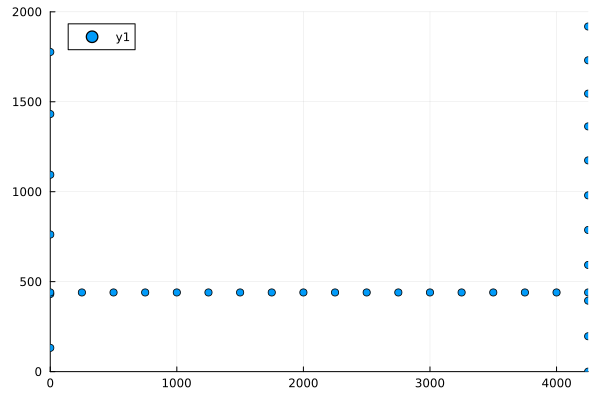

In [12]:
x = df.onset
y = df.frequency

plot(x , y, seriestype=:scatter, ylims = (0,2000), xlims = (0, maximum(x))) # a lot of noise at onset 0 and max(onset)

# Preprocessing
(will eventually happen in python, and preprocessed file will be given to Julia, with more difficult noise removal etc)

## Outlier/noise removal

In [5]:
# remove first and last frequency with noise
df = df[(df.onset .!= 0) .& (df.onset .!= maximum(x)), :]

,onset,duration,sample_rate,amplitude,phase,frequency,decay
,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,250,250,44100,0.499908,-1.53518,440.0,-1.79362e-5
2,250,250,44100,0.499908,1.53518,-440.0,-1.79362e-5
3,500,250,44100,0.499908,-1.64203,-440.0,2.93318e-6
4,500,250,44100,0.499908,1.64203,440.0,2.93318e-6
5,750,250,44100,4.17101e-5,-2.136,20169.0,-7.60292
6,750,250,44100,4.17101e-5,2.136,-20169.0,-7.60292
7,750,250,44100,0.499908,1.46394,-440.0,4.83648e-5
8,750,250,44100,0.499908,-1.46394,440.0,4.83648e-5
9,1000,250,44100,0.499909,-1.71327,-440.0,2.39577e-6


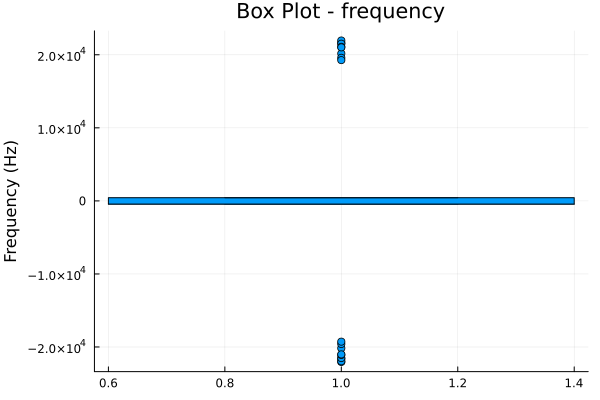

In [6]:
# Boxplot for outliers, notice: no outliers in complex space
boxplot(df.frequency, title = "Box Plot - frequency", ylabel = "Frequency (Hz)", legend = false)

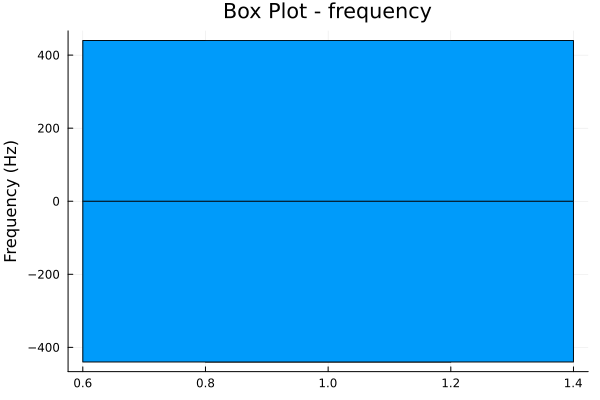

In [7]:
# Outlier removal
first_percentile = abs(percentile(df.frequency, 80)) # ensure always positive, 80% of the data closest to median
df_noNoise = df[(df.frequency .> -first_percentile-10) .& (df.frequency .< first_percentile+10),:]

boxplot(df_noNoise.frequency, title = "Box Plot - frequency", ylabel = "Frequency (Hz)", legend = false)


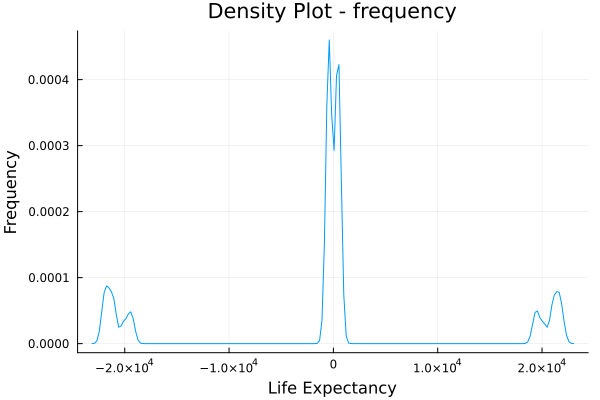

In [8]:
density(df.frequency , title = "Density Plot - frequency", ylabel = "Density", xlabel = "Frequency", legend = false)

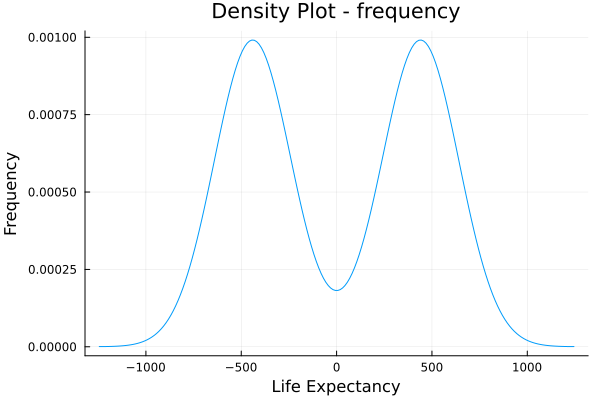

In [9]:
density(df_noNoise.frequency , title = "Density Plot - frequency", ylabel = "Frequency", xlabel = "Life Expectancy", legend = false)

# Linear regression

In [10]:
# ignore complex values (neg frequencies)
df_noNoiseNoComplex = df_noNoise[df_noNoise.frequency .> 0,:]

,onset,duration,sample_rate,amplitude,phase,frequency,decay,d
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,String
1,250,250,44100,0.499908,-1.53518,440.0,-1.79362e-5,(0.017802200406665296-0.4995910706221063j)
2,500,250,44100,0.499908,1.64203,440.0,2.93318e-6,(-0.03558194737470503+0.49864049386197556j)
3,750,250,44100,0.499908,-1.46394,440.0,4.83648e-5,(0.05331674351406422-0.4970566015533557j)
4,1000,250,44100,0.499909,1.71327,440.0,2.39577e-6,(-0.07098429648880103+0.49484319593194764j)
5,1250,250,44100,0.499909,-1.3927,440.0,-2.84349e-5,(0.08856098943039709-0.4920015674492656j)
6,1500,250,44100,0.499909,1.78451,440.0,-1.36656e-5,(-0.10602609278991341+0.4885355933232423j)
7,1750,250,44100,0.499908,-1.32146,440.0,3.43643e-5,(0.12335615170640932-0.48444950501688966j)
8,2000,250,44100,0.499909,1.85575,440.0,-1.49258e-5,(-0.1405294497066799+0.47975021662907097j)
9,2250,250,44100,0.499909,-1.25023,440.0,-2.58275e-5,(0.1575255624720385-0.4744412490720681j)


In [11]:
train, test = TrainTestSplit(df_noNoiseNoComplex,.75)

(9×10 DataFrame
 Row │ onset  duration  sample_rate  amplitude  phase     frequency  decay     ⋯
     │ Int64  Int64     Int64        Float64    Float64   Float64    Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   250       250        44100   0.499908  -1.53518      440.0  -1.79362e ⋯
   2 │   500       250        44100   0.499908   1.64203      440.0   2.93318e
   3 │  1000       250        44100   0.499909   1.71327      440.0   2.39577e
   4 │  1750       250        44100   0.499908  -1.32146      440.0   3.43643e
   5 │  2000       250        44100   0.499909   1.85575      440.0  -1.49258e ⋯
   6 │  2250       250        44100   0.499909  -1.25023      440.0  -2.58275e
   7 │  2500       250        44100   0.499908   1.92699      440.0   2.64761e
   8 │  3000       250        44100   0.499908   1.99822      440.0   7.94395e
   9 │  3250       250        44100   0.499909  -1.10775      440.0  -3.34806e ⋯
                        

In [12]:
# Fit a line for the data (linear regression)
fm = @formula(frequency ~ onset)
linearRegressor = lm(fm, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

frequency ~ 1 + onset

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error            t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)  440.0         2.33498e-5  18843805.29    <1e-48  440.0         440.0
onset         -4.64865e-9  1.11811e-8        -0.42    0.6900   -3.10878e-8    2.17905e-8
────────────────────────────────────────────────────────────────────────────────────────

In [13]:
# If standard deviation error < 0.05 and t big enough and r2 also big enough, r2(linearRegressor)
slope = GLM.coef(linearRegressor)[1]
stdError = GLM.coeftable(linearRegressor).cols[2][2]
#pval = GLM.coeftable(linearRegressor).cols[4][2]

#GLM.coeftable(linearRegressor)

if (stdError < 0.05) # if statistically significant
    frequencyPred = round(slope, digits = 2)
else 
    print("too much noise")
end

440.0

In [14]:
frequencyPred # this should be put in hierarchical structure
# TODO: build class that exports the frequency

440.0

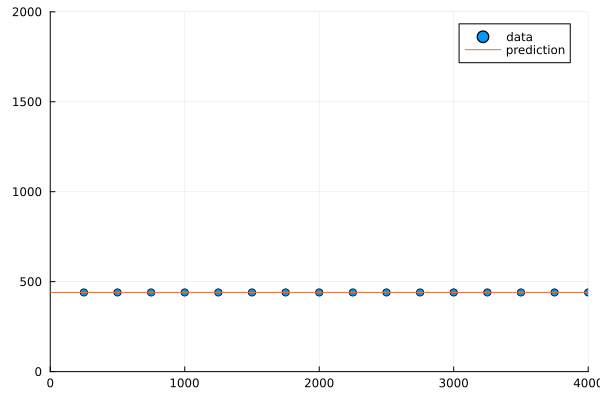

In [57]:
x = df.onset
y = df.frequency

xPred = range(0, maximum(df.onset), length=100)
yPred =  0*xPred .+ frequencyPred #ax+q

plot(x , y, seriestype=:scatter, ylims = (0,2000), xlims = (0, maximum(x)), label="data") # a lot of noise at onset 0 and max(onset)
plot!(xPred, yPred, label="prediction")


# Chakra knowledge

In [3]:
using Chakra #, Charm
push!(LOAD_PATH, "./src/") # TODO: load preprocessed data
using Resonances
include("./src/Sine.jl")

Main.Sine

In [6]:
MARGE = 5
PRED = frequencyPred

# TODO: moet van pairs zijn!!
f_0 = Resonances.getFrequencyBand(PRED-MARGE, PRED+MARGE, Sine).resonances # with marge

,onset,duration,sample_rate,amplitude,phase,frequency,decay,d
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,String
1,0,250,44100,0.499905,1.57079,440.0,0.000129689,(1.1636518252571698e-06+0.4999054798583427j)
2,250,250,44100,0.499908,-1.53518,440.0,-1.79362e-5,(0.017802200406665296-0.4995910706221063j)
3,500,250,44100,0.499908,1.64203,440.0,2.93318e-6,(-0.03558194737470503+0.49864049386197556j)
4,750,250,44100,0.499908,-1.46394,440.0,4.83648e-5,(0.05331674351406422-0.4970566015533557j)
5,1000,250,44100,0.499909,1.71327,440.0,2.39577e-6,(-0.07098429648880103+0.49484319593194764j)
6,1250,250,44100,0.499909,-1.3927,440.0,-2.84349e-5,(0.08856098943039709-0.4920015674492656j)
7,1500,250,44100,0.499909,1.78451,440.0,-1.36656e-5,(-0.10602609278991341+0.4885355933232423j)
8,1750,250,44100,0.499908,-1.32146,440.0,3.43643e-5,(0.12335615170640932-0.48444950501688966j)
9,2000,250,44100,0.499909,1.85575,440.0,-1.49258e-5,(-0.1405294497066799+0.47975021662907097j)


In [ ]:
plot(df.onset, df.frequency, seriestype=:scatter)

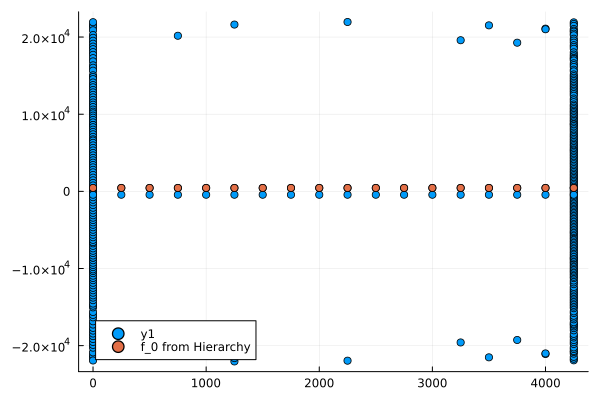

In [15]:
# Plot all the hierarchies that are extracted in red
plot(df.onset, df.frequency, seriestype=:scatter)
plot!(f_0.onset, f_0.frequency, seriestype=:scatter, label="f_0 from Hierarchy")

In [ ]:
# Build hierarchy from f_0

In [ ]:
# TODO: all the filtered data (x percentile) group as frequency ...
# Attach pitch value = 440 (pitch != frequency, pitch is more grouped resonances)

# Predictions (not needed atm)

In [19]:
# prediction
ypredicted_test = predict(linearRegressor, test)
ypredicted_train = predict(linearRegressor, train)

# Test Performance DataFrame (compute squared error)
performance_testdf = DataFrame(y_actual = test[!,:frequency], y_predicted = ypredicted_test)
performance_testdf.error = performance_testdf[!,:y_actual] - performance_testdf[!,:y_predicted]
performance_testdf.error_sq = performance_testdf.error.*performance_testdf.error

# Train Performance DataFrame (compute squared error)
performance_traindf = DataFrame(y_actual = train[!,:frequency], y_predicted = ypredicted_train)
performance_traindf.error = performance_traindf[!,:y_actual] - performance_traindf[!,:y_predicted]
performance_traindf.error_sq = performance_traindf.error.*performance_traindf.error ;

In [20]:
# MAPE function defination
function mape(performance_df)
    mape = mean(abs.(performance_df.error./performance_df.y_actual))
    return mape
end

mape (generic function with 1 method)

In [21]:
# RMSE function defination
function rmse(performance_df)
    rmse = sqrt(mean(performance_df.error.*performance_df.error))
    return rmse
end

rmse (generic function with 1 method)

In [22]:
# Test Error
println("Mean Absolute test error: ",mean(abs.(performance_testdf.error)), "\n")
println("Mean Aboslute Percentage test error: ",mape(performance_testdf), "\n")
println("Root mean square test error: ",rmse(performance_testdf), "\n")
println("Mean square test error: ",mean(performance_testdf.error_sq), "\n")

Mean Absolute test error: 1.7295364265074958e-5



Mean Aboslute Percentage test error: 3.930764738492491e-8



Root mean square test error: 2.0189902291409194e-5

Mean square test error: 4.076321545366502e-10



In [23]:
# Train  Error
println("Mean train error: ",mean(abs.(performance_traindf.error)), "\n")
println("Mean Absolute Percentage train error: ",mape(performance_traindf), "\n")
println("Root mean square train error: ",rmse(performance_traindf), "\n")
println("Mean square train error: ",mean(performance_traindf.error_sq), "\n")

Mean train error: 2.6264688870014652e-5

Mean Absolute Percentage train error: 5.96924748078166e-8

Root mean square train error: 2.9582476365470577e-5

Mean square train error: 8.751229079136253e-10



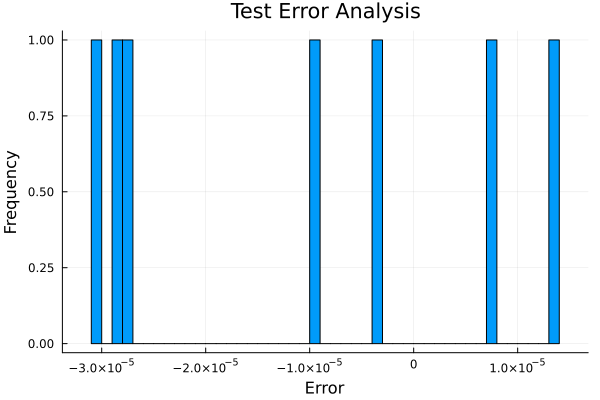

In [24]:
# Histogram of error to see if it's normally distributed  on test dataset
histogram(performance_testdf.error, bins = 50, title = "Test Error Analysis", ylabel = "Frequency", xlabel = "Error",legend = false)

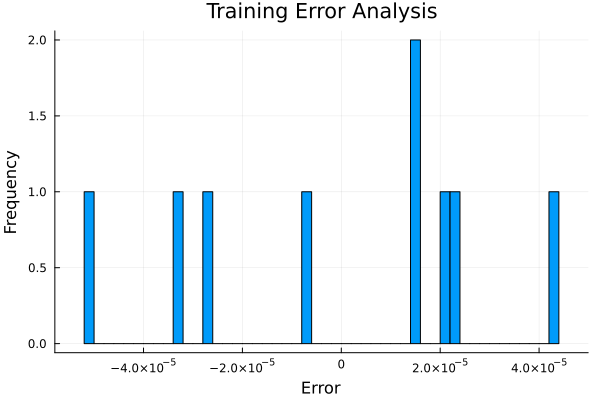

In [25]:
# Histogram of error to see if it's normally distributed  on train dataset
histogram(performance_traindf.error, bins = 50, title = "Training Error Analysis", ylabel = "Frequency", xlabel = "Error",legend = false)

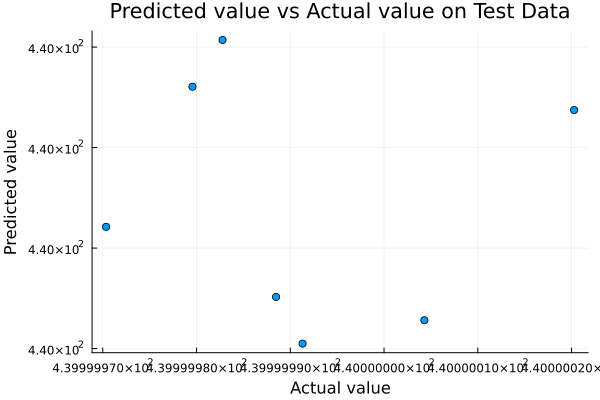

In [26]:
test_plot = scatter(performance_testdf[!,:y_actual],performance_testdf[!,:y_predicted], title = "Predicted value vs Actual value on Test Data", ylabel = "Predicted value", xlabel = "Actual value", legend = false)


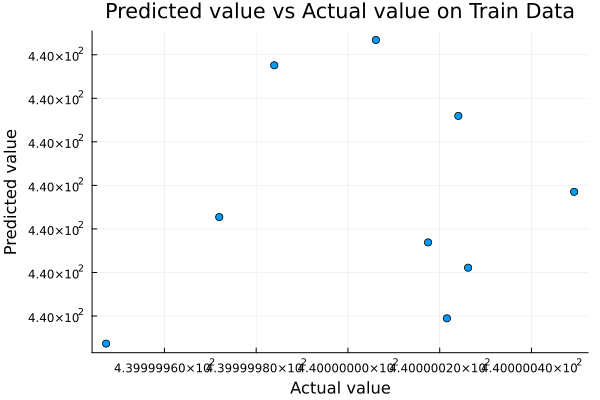

In [27]:
# Scatter plot of actual vs predicted values on train dataset
train_plot = scatter(performance_traindf[!,:y_actual],performance_traindf[!,:y_predicted], title = "Predicted value vs Actual value on Train Data", ylabel = "Predicted value", xlabel = "Actual value",legend = false)

In [28]:
# Cross Validation function defination
function cross_validation(train,k, fm = @formula(frequency ~ onset))
    a = collect(Kfold(size(train)[1], k))
    for i in 1:k
        row = a[i]
        temp_train = train[row,:]
        temp_test = train[setdiff(1:end, row),:]
        linearRegressor = lm(fm, temp_train)
        performance_testdf = DataFrame(y_actual = temp_test[!,:frequency], y_predicted = predict(linearRegressor, temp_test))
        performance_testdf.error = performance_testdf[!,:y_actual] - performance_testdf[!,:y_predicted]

        println("Mean error for set $i is ",mean(abs.(performance_testdf.error)))
    end
end

cross_validation (generic function with 2 methods)

In [29]:
cross_validation(train,10)

ErrorException: The value of k must be in [2, length(a)].